# Projet statistiques / dimanche 02 avril avant 23h59 sinon pénalité
## Objectif : retrouver la langue maternelle (origine) de l'auteur d'un texte écrit en anglais
## Plan :
- svm vs logistic regression
- fonction d'évaluation des modèles
    - plusieurs métriques : accuracy, précision, recall, f1.
        - utiliser la 'macro' f-mesure pour voir l'evaluation de chaque categorie.
    - matrice de confusion sur toutes les origines.
        - essayer de regrouper les origines difficiles à séparer (former des sortes de petites matrices)
- bag of words vs tf-idf
- Fonction modèle paramétrable.. **
- remove stop words or not
    - lister tous les mots du vocab avec les fréquences, pour trier une liste de stop words (on se décide nous même de la liste), lemmatization nécessaire pour cette étape.
- stemming or not
    - logiquement dans notre cas d'usage, ne pas le faire car on se concentre sur la recherche de singularités, alors que le stemming recherche la généralité.
- lemmatization or not
    - logiquement dans notre cas d'usage, ne pas le faire car on se concentre sur la recherche de singularités, alors que la lemmatization recherche la généralité.
- fonction qui liste tous les caractères et compte les fréquences, pour voir s'il y a des caractères bizarres (zero-width .. ?)
    - normalement pas de soucis car le prof a travaillé déjà dessus.
- séparation des mots
    - I’m, can’t : ne pas séparer pour notre cas d’usage.
- A explorer (on peut ajouter des choses dans le vecteur) :
    - on peut compter la ponctuation
        - visualisation possible avec des camemberts de couleurs
    - compter le nombre de caractères spéciaux (nombre d’apostrophes...)
        - aussi visualisation possible avec des camemberts de couleurs
    - longueur moyenne des phrases
    - nombre de mots différents dans le texte
    - fréquence de mot le plus utilisé
    - prendre chaque mot et voir s’il existe dans un dictionnaire, s’il n’est pas présent donc faute d'orthographe… puis peut être le nombre de fautes, ou faire le lien…
- avec un SVM on peut regarder les poids en sortie
- discrétisation ?
    - on peut dessiner une gaussienne avec les longueurs moyennes des phrases. si on a pas une gaussienne, regarder chaque catégorie
- nltk.pos_tag / spacy
    - la structure de la phrase peut différer selon la langue maternelle. (formulation de la phrase) chunk ?
        - ajouter une colonne la structure de la phrase
- Modèles en cascade :
    - séparer en groupes de langues exemple [KOR,CHI,JAP] [FRA,ESP,ITA,GER] [HIN,TEL] [ARA,TUR]
    - puis des modèles spécialisés
    - récupérer les proba pour chaque langue lors de la prédiction pour voir si y'a confusion entre les top premiers
    
## Bilan :
dernière séance où on fera la liste de tout ce qu'on a testé pour voir pourquoi ça a marché ou cela n'a pas marché.

## Rendu
envoyer avec l'adresse paris saclay !
mettre dans le corps du message, dans le rapport, dans le code : les noms du binome.

### un seul format de rapport : PDF.
simple, propre et lisible.
pas la peine de reproduire le cours, on virect au but.
contenu : journal d'expérimentation:
1. idée de base qu'on veut tester.
2. hipothèse
3. implémentation (codée, existente, compliquée...)
4. résultat
5. analyse : le fait de faire ça nous a fait gagner 3 points de F-mesure, et en analysant .. on remarque que enlever/ajouter/modifier... a un effet sur qqchose..
avoir un aspect critique : pourquoi l'implémentation de départ ne marche pas.. observations..

### code (notebook..) : archive ZIP ou TGZ.
code python : notebook ou fichier
si besoin de lib qui ne sont pas dans la lib de base: mettre un readme pour préciser, pareil pour les versions.
si compliqué à lancer : expliquer dans le readme.
ne pas joindre les data ni les modèles.

base line du prof : 0.63 de f-mesure.
test sur 1100 textes (100 de chaque langue) (à voir  si on utilise cette info)
on fait tourner dessus on obtient les prédictions finales.

joindre un fichier .txt et sur chaque ligne y'a la prédiction (attention à l'ordre des lignes)

In [ ]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns

# Lecture du dataframe
def load_data(path=r'./train.txt'):
    df = pd.read_csv(path, header=None, sep=":::",engine='python')
    df['text']=df[0].str.extract(r'^\([A-Z]{3}\) (.*)$')
    df['category']=df[0].str.extract(r'^\(([A-Z]{3})\)')
    df = df.drop([0], axis=1)
    return df
    
df = load_data()
df.tail()

text category
9895  Nowadays , more and more people go abroad , no...      CHI
9896  In accomplishing something that is risky comes...      KOR
9897  At the beginning of the 21st century , the inc...      SPA
9898  The number of cars in use across the world has...      HIN
9899  Many people think it is betters to have borad ...      CHI

In [ ]:
df['category'].value_counts()

GER    900
TUR    900
CHI    900
TEL    900
ARA    900
SPA    900
HIN    900
JPN    900
KOR    900
FRE    900
ITA    900
Name: category, dtype: int64

### Note :
Nous avons 11 langues maternelles (origines) avec 900 observations (texts) pour chaque origine.

In [ ]:
def draw_wordcloud(df):
  from wordcloud import WordCloud
  # Récupérer les catégories uniques
  categories = df['category'].unique()

  # Calculer le nombre total de wordclouds nécessaires et arrondir au multiple de 25 suivant
  total_wordclouds = len(categories)
  total_wordclouds += 25 - total_wordclouds % 25

  # Récupérer les catégories uniques
  categories = df['category'].unique()
  # Créer une grille de wordclouds
  fig, axes = plt.subplots(nrows=2, ncols=6, figsize=(20, 10))
  axes_flat = axes.flatten()

  for i, category in enumerate(categories):
      text = ' '.join(df[df['category'] == category]['text'])
      wordcloud = WordCloud(width=800, height=800, background_color='white').generate(text)
      ax = axes_flat[i]
      ax.imshow(wordcloud, interpolation='bilinear')
      ax.axis('off')
      ax.set_title(category)

  for ax in axes_flat[i+1:]:
      ax.axis('off')

  plt.tight_layout()
  plt.show()

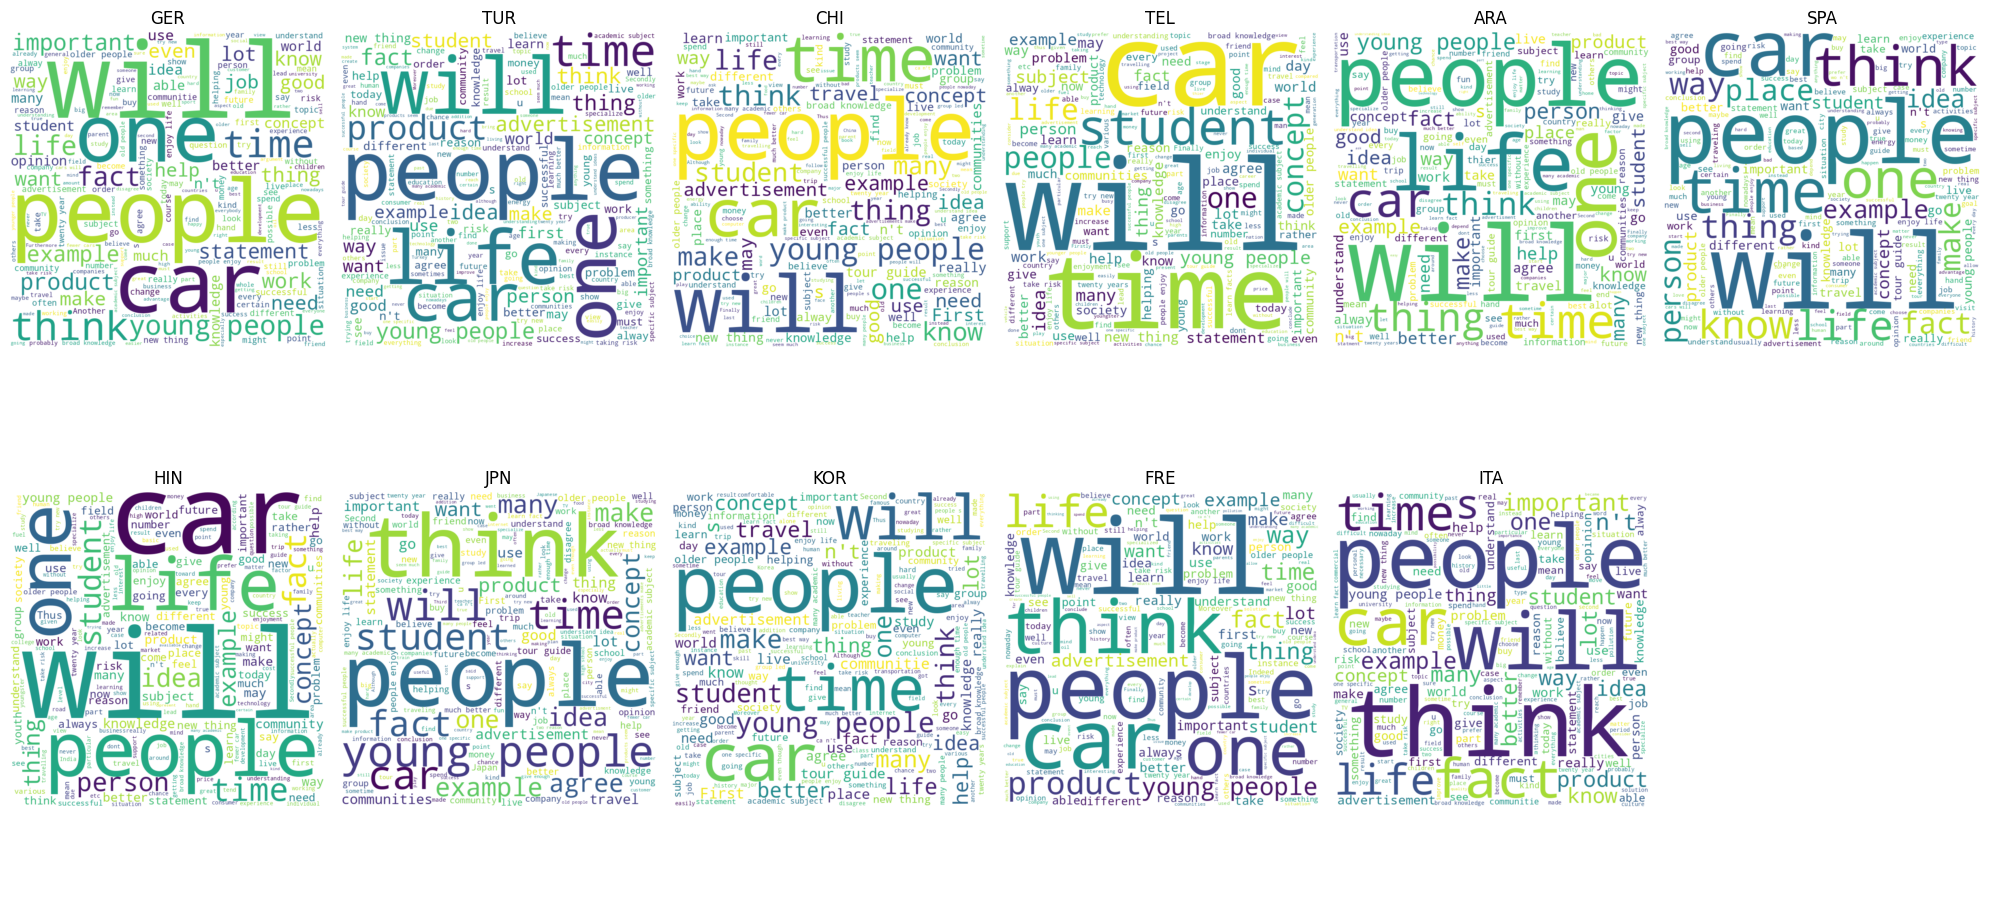

In [ ]:
draw_wordcloud(df)

In [ ]:
import pandas as pd
import plotly.express as px
import nltk
nltk.download('punkt')
from nltk import sent_tokenize
import plotly.graph_objects as go
import plotly.subplots as sp


# Séparer les phrases dans chaque texte
df["sentences"] = df["text"].apply(sent_tokenize)

# Distribution de la longueur des phrases pour chaque category
figs = []
categories = df["category"].unique()
for category in categories:
    df_category = df[df["category"] == category]
    df_category = df_category.explode("sentences")
    df_category["sentence_length"] = df_category["sentences"].str.split().apply(len)
    fig = px.histogram(df_category, x="sentence_length", nbins=100, title=f"Distribution de la longueur des phrases pour {category}")
    figs.append(fig)


# Afficher les figures en grille de 2x6
fig = sp.make_subplots(rows=2, cols=6, subplot_titles=categories, shared_yaxes=True)
for i, fig_category in enumerate(figs):
    row = i // 6 + 1
    col = i % 6 + 1
    fig.add_trace(fig_category.data[0], row=row, col=col)
    fig.update_xaxes(title_text="Longueur de la phrase", row=row, col=col)
    fig.update_yaxes(title_text="Fréquence", row=row, col=col)

fig.update_layout(showlegend=False, height=600, width=1200, title="Distribution de la longueur des phrases pour chaque catégorie")
fig.show()


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
import pandas as pd
import plotly.express as px
import nltk
nltk.download('punkt')
from nltk import word_tokenize
import plotly.graph_objects as go
import plotly.subplots as sp

# Séparer les mots dans chaque texte
df["words"] = df["text"].apply(word_tokenize)

# Distribution de la longueur des mots pour chaque category
figs = []
categories = df["category"].unique()
for category in categories:
    df_category = df[df["category"] == category]
    df_category = df_category.explode("words")
    df_category["word_length"] = df_category["words"].apply(len)
    fig = px.box(df_category, y="word_length", title=f"Distribution de la longueur des mots pour {category}")
    figs.append(fig)


# Afficher les figures en grille de 2x6
fig = sp.make_subplots(rows=2, cols=6, subplot_titles=categories)
for i, fig_category in enumerate(figs):
    row = i // 6 + 1
    col = i % 6 + 1
    fig.add_trace(fig_category.data[0], row=row, col=col)
    fig.update_yaxes(title_text="Longueur des mots", row=row, col=col)

fig.update_layout(showlegend=False, height=600, width=1200, title="Distribution de la longueur des mots pour chaque catégorie")
fig.show()


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
import pandas as pd
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
from nltk import word_tokenize, pos_tag
import plotly.graph_objects as go
import plotly.subplots as sp


# Distribution des parties du discours
figs = []
categories = df["category"].unique()
for category in categories:
    df_category = df[df["category"] == category]
    pos_counts = {"NN": 0, "NNS": 0, "NNP": 0, "NNPS": 0, "VB": 0, "VBD": 0, "VBG": 0, "VBN": 0, "VBP": 0, "VBZ": 0, "JJ": 0, "JJR": 0, "JJS": 0, "RB": 0, "RBR": 0, "RBS": 0}
    for text in df_category["text"]:
        tokens = word_tokenize(text)
        pos_tags = pos_tag(tokens)
        for tag in pos_tags:
            if tag[1] in pos_counts:
                pos_counts[tag[1]] += 1
    fig = go.Figure(data=[go.Bar(x=list(pos_counts.keys()), y=list(pos_counts.values()))])
    fig.update_layout(title=f"Distribution des parties du discours pour {category}")
    figs.append(fig)

# Afficher les figures en grille de 2x6
fig = sp.make_subplots(rows=2, cols=6, subplot_titles=categories)
for i, fig_category in enumerate(figs):
    row = i // 6 + 1
    col = i % 6 + 1
    fig.add_trace(fig_category.data[0], row=row, col=col)
    fig.update_xaxes(title_text="Parties du discours", row=row, col=col)
    fig.update_yaxes(title_text="Fréquence", row=row, col=col)

fig.update_layout(showlegend=False, height=600, width=1200, title="Distribution des parties du discours pour chaque catégorie")
fig.show()


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


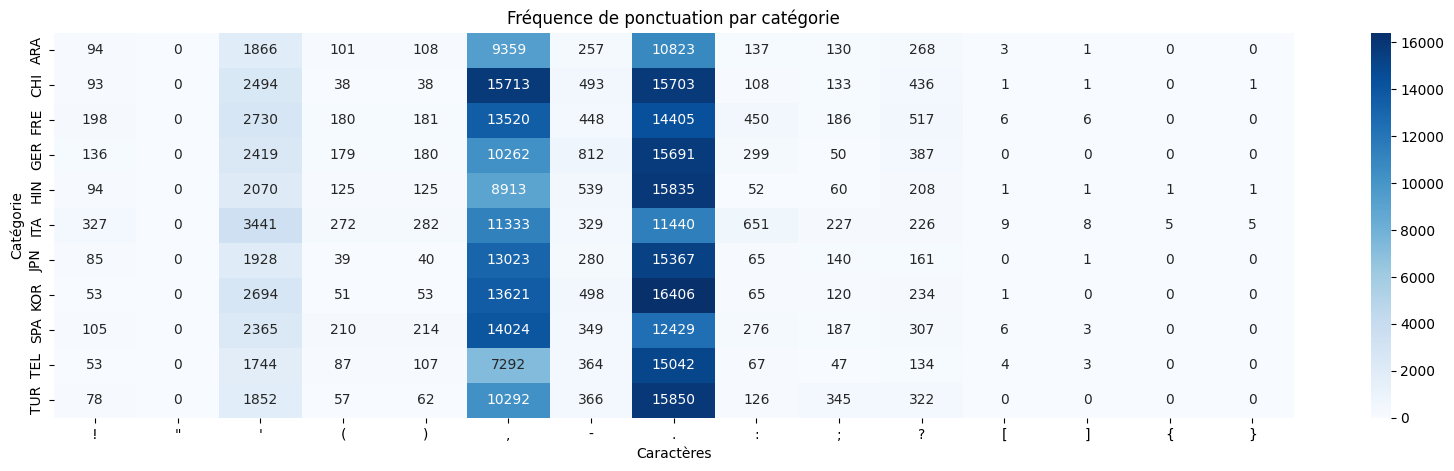


Normalisation de la fréquence de ponctuation par catégorie


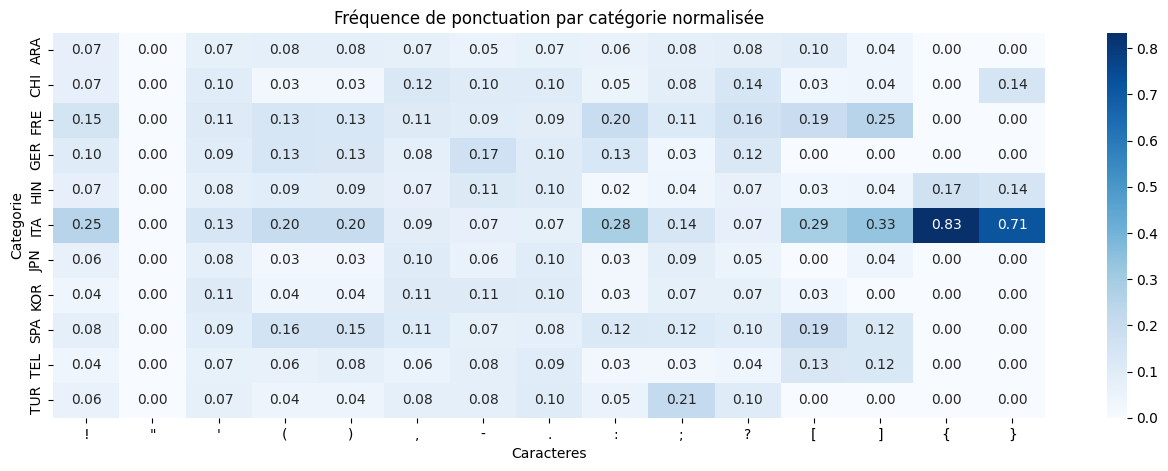

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# grouper puis concatener les textes de chaque catégorie
df_punct = df.groupby(['category'])['text'].apply(''.join).reset_index()
punctuation = ['.', ',', ';', ':', '?', '!', '-', '(', ')', '[', ']', '{', '}', '\'', '\"']
for p in punctuation:
    df_punct[p] = df_punct['text'].apply(lambda x: x.count(p))
    
plt.figure(figsize=(20, 5))
heatmap_data = pd.pivot_table(df_punct, values=punctuation, index=['category'], aggfunc=np.sum)
sns.heatmap(heatmap_data, cmap='Blues', annot=True, fmt='.0f')
plt.title("Fréquence de ponctuation par catégorie")
plt.xlabel("Caractères")
plt.ylabel("Catégorie")
plt.show()

# normalisation par colonne (par caractère)
print("\nNormalisation de la fréquence de ponctuation par catégorie")
for p in punctuation:
    df_punct[p] = df_punct[p] / df_punct[p].sum()

plt.figure(figsize=(16, 5))
heatmap_data = pd.pivot_table(df_punct, values=punctuation, index=['category'], aggfunc=np.sum)
sns.heatmap(heatmap_data, cmap='Blues', annot=True, fmt='.2f')
plt.title("Fréquence de ponctuation par catégorie normalisée")
plt.xlabel("Caracteres")
plt.ylabel("Categorie")
plt.show()

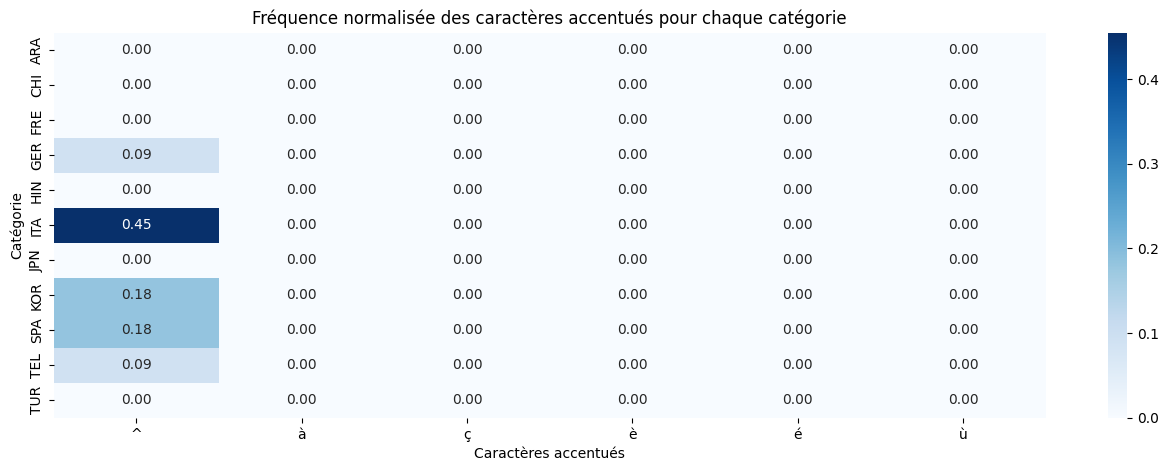

In [ ]:
# Fréquence normalisée des caractères accentués pour chaque catégorie
df_car = df.groupby(['category'])['text'].apply(''.join).reset_index()
caracteres = ['é', 'è', 'ç', 'à', 'ù', '^']
for c in caracteres:
    df_car[c] = df_car['text'].apply(lambda x: x.count(c))
for c in caracteres:
    df_car[c] = df_car[c] / df_car[c].sum()

plt.figure(figsize=(16, 5))
heatmap_data = pd.pivot_table(df_car, values=caracteres, index=['category'], aggfunc=np.sum)
sns.heatmap(heatmap_data, cmap='Blues', annot=True, fmt='.2f')
plt.title("Fréquence normalisée des caractères accentués pour chaque catégorie")
plt.xlabel("Caractères accentués")
plt.ylabel("Catégorie")
plt.show()

In [ ]:
# Nombre de mots par texte pour chaque catégorie
import plotly.express as px

df['text_length'] = df['text'].apply(lambda x: len(x.split()))

fig = px.box(df, x='category', y='text_length')
fig.update_layout(title="Nombre de mots",
                  xaxis_title="Catégorie",
                  yaxis_title="Nombre de mots par texte pour chaque catégorie")
fig.show()

In [ ]:
# Distribution du nombre de mots par catégorie
fig = px.histogram(df, x="text_length", color="category", nbins=50,
                   marginal="box", title="Distribution du nombre de mots par catégorie")

fig.update_layout(xaxis_title="Nombre de mots", yaxis_title="Fréquence")
fig.show()

# ----------------------------- Modelisation notebook -----------------------------

## Split data

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit

def split_data(X_to_split, y_to_split, test_size=0.2, random_state=42):
    # Séparation des données en train et test avec Stratified Shuffle Split
    sss = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=random_state)
    train_index, test_index = next(sss.split(X_to_split, y_to_split))
    X_train, y_train = X.iloc[train_index], y.iloc[train_index]
    X_test, y_test = X.iloc[test_index], y.iloc[test_index]

    return X_train, X_test, y_train, y_test

def get_train_dev_test_data(X_to_split, y_to_split, test_size=0.2, random_state=42, verbose=True):
  # Split data to Train, Test (step 1)
  X_train, X_test, y_train, y_test = split_data(X, y, test_size, random_state)
  # Split test data to Test, Dev (step 2)
  X_test, X_dev, y_test, y_dev = split_data(X_test, y_test, test_size=0.5, random_state=42)

  if verbose:
    # Affichage du shape de chaque variable
    print("Shape de X_train :", X_train.shape)
    print("Shape de y_train :", y_train.shape)
    print("Shape de X_dev :", X_dev.shape)
    print("Shape de y_dev :", y_dev.shape)
    print("Shape de X_test :", X_test.shape)
    print("Shape de y_test :", y_test.shape)

    # Final data check
    print("\ny_train split:\n", y_train.value_counts())
    print("\ny_dev split:\n", y_dev.value_counts())
    print("\ny_test split:\n", y_test.value_counts())
  
  return X_train, X_dev, X_test, y_train, y_dev, y_test

# load data
df = load_data()

# variables et target
X = df['text']
y = df['category']

# split
X_train, X_dev, X_test, y_train, y_dev, y_test = get_train_dev_test_data(X, y, test_size=0.2, random_state=42, verbose=True)

Shape de X_train : (7920,)
Shape de y_train : (7920,)
Shape de X_dev : (990,)
Shape de y_dev : (990,)
Shape de X_test : (990,)
Shape de y_test : (990,)

y_train split:
 ARA    720
TUR    720
GER    720
CHI    720
JPN    720
ITA    720
SPA    720
KOR    720
TEL    720
HIN    720
FRE    720
Name: category, dtype: int64

y_dev split:
 ITA    104
FRE     96
HIN     92
KOR     92
JPN     91
ARA     89
CHI     88
SPA     88
TUR     87
GER     82
TEL     81
Name: category, dtype: int64

y_test split:
 SPA    107
FRE    100
TUR     93
KOR     92
JPN     91
CHI     90
GER     89
ARA     86
TEL     85
HIN     83
ITA     74
Name: category, dtype: int64


## Label encoder
On crée une instance qui sera utilisée tout au long du projet

In [ ]:
from sklearn.preprocessing import LabelEncoder

def get_label_encoder_for(y_to_encode):
  label_encoder = LabelEncoder()
  label_encoder.fit(y_to_encode) # y = df['category'] or df['group'] ...

  # to inverse transform we use :
  #label_encoder.inverse_transform([0, 1, 2, 3, 4])
  d = zip([i for i in range(len(y_to_encode.unique()))], label_encoder.inverse_transform([i for i in range(len(y_to_encode.unique()))]))
  class_labels_dict = {}
  for k,v in d:
      class_labels_dict[k] = v
  
  return label_encoder, class_labels_dict

label_encoder, class_labels_dict = get_label_encoder_for(df['category'])
print("Labelled classes : ", class_labels_dict)

Labelled classes :  {0: 'ARA', 1: 'CHI', 2: 'FRE', 3: 'GER', 4: 'HIN', 5: 'ITA', 6: 'JPN', 7: 'KOR', 8: 'SPA', 9: 'TEL', 10: 'TUR'}


## Fonction d'évaluation

In [ ]:

def print_metrics(y_test, y_pred):
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
    # micro : Calculate metrics globally by counting the total true positives, false negatives and false positives.
    # macro : faire le calcul étiquette par étiquette, puis faire la moyenne
    labels_list=['ARA','CHI','FRE','GER','HIN','ITA','JPN','KOR','SPA','TEL','TUR']
    average_param = "macro"
    print("\nAccuracy ", accuracy_score(y_test, y_pred))

    print("\n- Precision -", average_param)
    tmp = "\n"+str(list(zip(labels_list, precision_score(y_test, y_pred, average=None, zero_division=1))))
    print("precision by language :", tmp.replace("),",")\n").replace("[",'').replace("]",''))
    print("\nprecision score ", precision_score(y_test, y_pred, average=average_param, zero_division=1))

    print("\n- Recall -", average_param)
    tmp = "\n"+str(list(zip(labels_list, recall_score(y_test, y_pred, average=None, zero_division=1))))
    print("recall by language ", tmp.replace("),",")\n").replace("[",'').replace("]",''))
    print("\nrecall score ",   recall_score(y_test, y_pred, average=average_param, zero_division=1))
    tmp = "\n"+str(list(zip(labels_list, f1_score(y_test, y_pred, average=None, zero_division=1))))
    
    print("\n- F1 -", average_param)
    print("f1 by language ", tmp.replace("),",")\n").replace("[",'').replace("]",''))
    print("\nf1 score ", f1_score(y_test, y_pred, average=average_param, zero_division=1))


def draw_confusion_matrix(y_test, y_pred, langs_label=['ARA',\
 'CHI',
 'FRE',
 'GER',
 'HIN',
 'ITA',
 'JPN',
 'KOR',
 'SPA',
 'TEL',
 'TUR'], 
                          class_labels_dict=class_labels_dict):
  
  from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
  import plotly.express as px
  lang2num = {v: k for k, v in class_labels_dict.items()}
  lang_list =  [ lang2num[k] for k in langs_label] 
  data = confusion_matrix(y_true=y_test, y_pred=y_pred, labels=lang_list)
  fig = px.imshow(data,
                  labels=dict(x="Languages y_test", y="Languages y_pred", color="confusion"),
                  x=langs_label,
                  y=langs_label,
                  text_auto=True,
                  aspect="auto")
  fig.update_xaxes(side="top")
  fig.show()


def evaluation(y_test, y_pred, labels_list=['ARA',\
'CHI',
'FRE',
'GER',
'HIN',
'ITA',
'JPN',
'KOR',
'SPA',
'TEL',
'TUR'],
              class_labels_dict:dict=class_labels_dict, 
              exclude:list=[""]):
  print("\n-- EVALUATION --\n")
  draw_confusion_matrix(y_test, y_pred, langs_label=labels_list, class_labels_dict=class_labels_dict)

  print_metrics(y_test, y_pred)


## Fonction de test de plusiurs modèles et plusieurs méthodes de vectorisation du texte



In [ ]:
# Fonction de test de plusiurs modèles et plusieurs méthodes de vectorisation du texte
def train_and_evaluate_model(model_name, vectorizer_type, X_train, X_dev, X_test, y_train, y_dev, y_test, label_encoder, labels_list=['ARA',\
'CHI',
'FRE',
'GER',
'HIN',
'ITA',
'JPN',
'KOR',
'SPA',
'TEL',
'TUR'],
              class_labels_dict:dict=class_labels_dict):
  from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
  from sklearn.linear_model import LogisticRegression
  from sklearn.svm import SVC
  from sklearn.metrics import accuracy_score

  # Vectorisation des données textuelles
  if vectorizer_type == 'count_vectorizer':
      vectorizer = CountVectorizer()
  elif vectorizer_type == 'tfidf_vectorizer':
      vectorizer = TfidfVectorizer()
  else:
      raise ValueError("Vectorizer type should be 'count_vectorizer' or 'tfidf_vectorizer'.")
      
  X_train_vectors = vectorizer.fit_transform(X_train)
  X_dev_vectors = vectorizer.transform(X_dev)
  X_test_vectors = vectorizer.transform(X_test)

  # Transformer les catégories en nombres entiers avec label encoder déjà entrainé 
  y_train_labels = label_encoder.transform(y_train)
  y_dev_labels = label_encoder.transform(y_dev)
  y_test_labels = label_encoder.transform(y_test)

  # Entraîner le modèle correspondant au nom spécifié
  if model_name == 'logistic_regression':
      clf = LogisticRegression()
  elif model_name == 'svm':
      clf = SVC()
  else:
      raise ValueError("Model name should be 'logistic_regression' or 'svm'.")
      
  clf.fit(X_train_vectors, y_train_labels)

  # Prédiction sur les données de développement (dev)
  y_pred_dev = clf.predict(X_dev_vectors)

  # Calcul de l'accuracy sur les données de développement (dev)
  accuracy_dev = accuracy_score(y_dev_labels, y_pred_dev)
  print(f"Accuracy sur les données de dev avec {vectorizer_type} et {model_name}: {accuracy_dev:.3f}")

  # Prédiction sur les données de test
  y_pred_test = clf.predict(X_test_vectors)

  # Calcul de l'accuracy sur les données de test
  accuracy_test = accuracy_score(y_test_labels, y_pred_test)
  print(f"Accuracy sur les données de test avec {vectorizer_type} et {model_name}: {accuracy_test:.3f}")

  # Evaluation function
  evaluation(y_test_labels, y_pred_test, labels_list, class_labels_dict)


## Logistic regression
### Logistic regression avec Bag of Words

In [ ]:
# Logistic regression avec Bag of Words 
train_and_evaluate_model('logistic_regression', 'count_vectorizer', X_train, X_dev, X_test, y_train, y_dev, y_test, label_encoder)

Accuracy sur les données de dev avec count_vectorizer et logistic_regression: 0.905
Accuracy sur les données de test avec count_vectorizer et logistic_regression: 0.901

-- EVALUATION --



/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression




Accuracy  0.901010101010101

- Precision - macro
precision by language : 
('ARA', 0.8690476190476191)
 ('CHI', 0.8736842105263158)
 ('FRE', 0.925531914893617)
 ('GER', 0.8947368421052632)
 ('HIN', 0.9125)
 ('ITA', 0.9240506329113924)
 ('JPN', 0.9010989010989011)
 ('KOR', 0.8913043478260869)
 ('SPA', 0.9347826086956522)
 ('TEL', 0.9090909090909091)
 ('TUR', 0.88)

precision score  0.9014389078359778

- Recall - macro
recall by language  
('ARA', 0.8488372093023255)
 ('CHI', 0.9222222222222223)
 ('FRE', 0.87)
 ('GER', 0.9550561797752809)
 ('HIN', 0.8795180722891566)
 ('ITA', 0.9864864864864865)
 ('JPN', 0.9010989010989011)
 ('KOR', 0.8913043478260869)
 ('SPA', 0.8037383177570093)
 ('TEL', 0.9411764705882353)
 ('TUR', 0.946236559139785)

recall score  0.9041522514986808

- F1 - macro
f1 by language  
('ARA', 0.8588235294117648)
 ('CHI', 0.8972972972972973)
 ('FRE', 0.8969072164948454)
 ('GER', 0.9239130434782609)
 ('HIN', 0.8957055214723926)
 ('ITA', 0.954248366013072)
 ('JPN', 0.9010989

### Logistic regression avec TF-IDF

In [ ]:
# Logistic regression avec TF IDF 
train_and_evaluate_model('logistic_regression', 'tfidf_vectorizer', X_train, X_dev, X_test, y_train, y_dev, y_test, label_encoder)

Accuracy sur les données de dev avec tfidf_vectorizer et logistic_regression: 0.825
Accuracy sur les données de test avec tfidf_vectorizer et logistic_regression: 0.828

-- EVALUATION --



/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression




Accuracy  0.8282828282828283

- Precision - macro
precision by language : 
('ARA', 0.8493150684931506)
 ('CHI', 0.8020833333333334)
 ('FRE', 0.8617021276595744)
 ('GER', 0.84375)
 ('HIN', 0.7590361445783133)
 ('ITA', 0.9041095890410958)
 ('JPN', 0.8152173913043478)
 ('KOR', 0.8021978021978022)
 ('SPA', 0.8173076923076923)
 ('TEL', 0.8333333333333334)
 ('TUR', 0.8367346938775511)

precision score  0.8295261069205631

- Recall - macro
recall by language  
('ARA', 0.7209302325581395)
 ('CHI', 0.8555555555555555)
 ('FRE', 0.81)
 ('GER', 0.9101123595505618)
 ('HIN', 0.7590361445783133)
 ('ITA', 0.8918918918918919)
 ('JPN', 0.8241758241758241)
 ('KOR', 0.7934782608695652)
 ('SPA', 0.794392523364486)
 ('TEL', 0.8823529411764706)
 ('TUR', 0.8817204301075269)

recall score  0.8294223785298486

- F1 - macro
f1 by language  
('ARA', 0.779874213836478)
 ('CHI', 0.8279569892473118)
 ('FRE', 0.8350515463917526)
 ('GER', 0.8756756756756756)
 ('HIN', 0.7590361445783133)
 ('ITA', 0.8979591836734694)
 

## SVM
### SVM avec Bag of Words

In [ ]:
# SVM avec Bag of Words
train_and_evaluate_model('svm', 'count_vectorizer', X_train, X_dev, X_test, y_train, y_dev, y_test, label_encoder)

Accuracy sur les données de dev avec count_vectorizer et svm: 0.725
Accuracy sur les données de test avec count_vectorizer et svm: 0.707

-- EVALUATION --




Accuracy  0.7070707070707071

- Precision - macro
precision by language : 
('ARA', 0.574468085106383)
 ('CHI', 0.6956521739130435)
 ('FRE', 0.7340425531914894)
 ('GER', 0.7029702970297029)
 ('HIN', 0.6933333333333334)
 ('ITA', 0.6555555555555556)
 ('JPN', 0.6388888888888888)
 ('KOR', 0.7808219178082192)
 ('SPA', 0.7473684210526316)
 ('TEL', 0.8333333333333334)
 ('TUR', 0.7619047619047619)

precision score  0.7107581201015766

- Recall - macro
recall by language  
('ARA', 0.627906976744186)
 ('CHI', 0.7111111111111111)
 ('FRE', 0.69)
 ('GER', 0.797752808988764)
 ('HIN', 0.6265060240963856)
 ('ITA', 0.7972972972972973)
 ('JPN', 0.7582417582417582)
 ('KOR', 0.6195652173913043)
 ('SPA', 0.6635514018691588)
 ('TEL', 0.8235294117647058)
 ('TUR', 0.6881720430107527)

recall score  0.7094212773195839

- F1 - macro
f1 by language  
('ARA', 0.6)
 ('CHI', 0.7032967032967032)
 ('FRE', 0.711340206185567)
 ('GER', 0.7473684210526316)
 ('HIN', 0.6582278481012659)
 ('ITA', 0.7195121951219513)
 ('JPN'

### SVM avec TF IDF

In [ ]:
# SVM avec TF IDF
train_and_evaluate_model('svm', 'tfidf_vectorizer', X_train, X_dev, X_test, y_train, y_dev, y_test, label_encoder)

Accuracy sur les données de dev avec tfidf_vectorizer et svm: 0.925
Accuracy sur les données de test avec tfidf_vectorizer et svm: 0.933

-- EVALUATION --




Accuracy  0.9333333333333333

- Precision - macro
precision by language : 
('ARA', 0.9518072289156626)
 ('CHI', 0.9230769230769231)
 ('FRE', 0.9789473684210527)
 ('GER', 0.9560439560439561)
 ('HIN', 0.8690476190476191)
 ('ITA', 1.0)
 ('JPN', 0.8947368421052632)
 ('KOR', 0.9213483146067416)
 ('SPA', 0.9428571428571428)
 ('TEL', 0.927710843373494)
 ('TUR', 0.91)

precision score  0.9341432944043504

- Recall - macro
recall by language  
('ARA', 0.9186046511627907)
 ('CHI', 0.9333333333333333)
 ('FRE', 0.93)
 ('GER', 0.9775280898876404)
 ('HIN', 0.8795180722891566)
 ('ITA', 1.0)
 ('JPN', 0.9340659340659341)
 ('KOR', 0.8913043478260869)
 ('SPA', 0.9252336448598131)
 ('TEL', 0.9058823529411765)
 ('TUR', 0.978494623655914)

recall score  0.9339968227292587

- F1 - macro
f1 by language  
('ARA', 0.9349112426035502)
 ('CHI', 0.9281767955801106)
 ('FRE', 0.9538461538461539)
 ('GER', 0.9666666666666667)
 ('HIN', 0.8742514970059881)
 ('ITA', 1.0)
 ('JPN', 0.913978494623656)
 ('KOR', 0.9060773480

## Modèles en cascade
Grouper les catégories qui se ressemblent en se référent à la matrice de confusion, on prend les catégories que le modèle confond et on les mets dans un même groupe. Des modèles spécialisés seront créés par la suite pour chaque groupe afin de diminuer la confusion.

In [ ]:
"""
0:[ARA,TUR]; 1:[KOR,CHI,JPN] 2:[FRE,SPA,ITA,GER]; 3:[HIN,TEL] 
"""
lang_to_group = {'ARA':1, 'CHI':1, 'FRE':2, 'GER':2, 'HIN':3, 'ITA':2, 'JPN':1, 'KOR':1, 'SPA':2, 'TEL':3, 'TUR':0}
label_to_group = {i:lang_to_group[class_labels_dict[i]] for i in range(len(class_labels_dict))}

print(lang_to_group)
print(label_to_group)

{'ARA': 1, 'CHI': 1, 'FRE': 2, 'GER': 2, 'HIN': 3, 'ITA': 2, 'JPN': 1, 'KOR': 1, 'SPA': 2, 'TEL': 3, 'TUR': 0}
{0: 1, 1: 1, 2: 2, 3: 2, 4: 3, 5: 2, 6: 1, 7: 1, 8: 2, 9: 3, 10: 0}


In [ ]:
# load data
df = load_data()

# créer les groupes
df['group'] = df['category'].apply(lambda x: lang_to_group[x])

# variables et target
X = df['text']
y = df['group'] # target = 'group' aulieu de category

# split
X_train, X_dev, X_test, y_train, y_dev, y_test = get_train_dev_test_data(X, y, test_size=0.2, random_state=42, verbose=True)


Shape de X_train : (7920,)
Shape de y_train : (7920,)
Shape de X_dev : (990,)
Shape de y_dev : (990,)
Shape de X_test : (990,)
Shape de y_test : (990,)

y_train split:
 1    2880
2    2880
3    1440
0     720
Name: group, dtype: int64

y_dev split:
 2    371
1    363
3    161
0     95
Name: group, dtype: int64

y_test split:
 2    369
1    356
3    180
0     85
Name: group, dtype: int64


In [ ]:
# label pour les groupes
label_encoder, class_labels_dict = get_label_encoder_for(df['group']) # df['group'] au lieu de df['category']
print("Labelled classes : ", class_labels_dict)

# SVM avec TF IDF
train_and_evaluate_model('svm', 'tfidf_vectorizer', X_train, X_dev, X_test, y_train, y_dev, y_test, label_encoder, labels_list=list(class_labels_dict.keys()), class_labels_dict=class_labels_dict)

Labelled classes :  {0: 0, 1: 1, 2: 2, 3: 3}
Accuracy sur les données de dev avec tfidf_vectorizer et svm: 0.949
Accuracy sur les données de test avec tfidf_vectorizer et svm: 0.952

-- EVALUATION --




Accuracy  0.9515151515151515

- Precision - macro
precision by language : 
('ARA', 0.9714285714285714)
 ('CHI', 0.9354838709677419)
 ('FRE', 0.9421052631578948)
 ('GER', 1.0)

precision score  0.962254426388552

- Recall - macro
recall by language  
('ARA', 0.8)
 ('CHI', 0.9775280898876404)
 ('FRE', 0.9701897018970189)
 ('GER', 0.9333333333333333)

recall score  0.9202627812794981

- F1 - macro
f1 by language  
('ARA', 0.8774193548387097)
 ('CHI', 0.956043956043956)
 ('FRE', 0.9559412550066756)
 ('GER', 0.9655172413793104)

f1 score  0.938730451817163


## LSTM avec Tokenizer

Techniquement, il est possible d'entraîner un modèle LSTM avec CountVectorizer. Cependant, les modèles LSTM sont généralement plus performants lorsqu'ils sont entraînés avec des données qui ont été traitées avec des méthodes de prétraitement telles que Tokenizer.

L'une des raisons pour lesquelles Tokenizer est plus efficace pour l'entraînement de modèles LSTM est qu'il est capable de conserver la séquence des mots dans une phrase, tandis que CountVectorizer ne prend en compte que la fréquence des mots dans un document. Les modèles LSTM sont particulièrement utiles pour comprendre la séquence des mots et des phrases dans un texte.

En outre, CountVectorizer est plus efficace pour l'entraînement de modèles de classification traditionnels tels que les SVM.

In [ ]:

def LSTM_train_and_evaluate_model(model_name, vectorizer_type, X_train, X_dev, X_test, y_train, y_dev, y_test, label_encoder):
    import tensorflow as tf
    from tensorflow.keras.layers import LSTM, Dense, Dropout
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.preprocessing.text import Tokenizer
    from tensorflow.keras.preprocessing.sequence import pad_sequences
    from sklearn.metrics import accuracy_score
    import numpy as np

    # Configuration du modèle LSTM
    max_words = 10000
    max_len = 200
    embedding_dim = 100
    lstm_units = 16
    dropout_rate = 0.2

    epochs = 5
    batch_size = 8
    
    # Tokenisation des données textuelles
    tokenizer = Tokenizer(num_words=max_words)
    if vectorizer_type == 'tokenizer':
        pass
    else:
        raise ValueError("Vectorizer type should be 'tokenizer'.")
    tokenizer.fit_on_texts(X_train)
    
    X_train_sequences = tokenizer.texts_to_sequences(X_train)
    X_dev_sequences = tokenizer.texts_to_sequences(X_dev)
    X_test_sequences = tokenizer.texts_to_sequences(X_test)
    
    X_train_padded = pad_sequences(X_train_sequences, maxlen=max_len)
    X_dev_padded = pad_sequences(X_dev_sequences, maxlen=max_len)
    X_test_padded = pad_sequences(X_test_sequences, maxlen=max_len)
    
    # Transformer les catégories en nombres entiers avec label encoder déjà entrainé 
    y_train_labels = label_encoder.transform(y_train)
    y_dev_labels = label_encoder.transform(y_dev)
    y_test_labels = label_encoder.transform(y_test)
    
    # Entraîner le modèle correspondant au nom spécifié
    if model_name == 'lstm':
      model = Sequential()
      model.add(tf.keras.layers.Embedding(max_words, embedding_dim, input_length=max_len))
      #model.add(LSTM(units=lstm_units, dropout=dropout_rate, return_sequences=True))
      model.add(LSTM(units=lstm_units, dropout=dropout_rate))
      model.add(Dense(len(label_encoder.classes_), activation='softmax'))
      model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
      model.fit(X_train_padded, y_train_labels, validation_data=(X_dev_padded, y_dev_labels), epochs=epochs, batch_size=batch_size)
    else:
      raise ValueError("Model name should be 'lstm'.")
    
    # Prédiction sur les données de développement (dev)
    y_pred_dev_proba = model.predict(X_dev_padded)
    y_pred_dev = np.argmax(y_pred_dev_proba, axis=1)
    # Calcul de l'accuracy sur les données de développement (dev)
    accuracy_dev = accuracy_score(y_dev_labels, y_pred_dev)
    print(f"Accuracy sur les données de dev avec {vectorizer_type} et {model_name}: {accuracy_dev:.3f}")

    # Prédiction sur les données de test
    y_pred_test_proba = model.predict(X_test_padded)
    y_pred_test = np.argmax(y_pred_test_proba, axis=1)
    # Calcul de l'accuracy sur les données de test
    accuracy_test = accuracy_score(y_test_labels, y_pred_test)
    print(f"Accuracy sur les données de test avec {vectorizer_type} et {model_name}: {accuracy_test:.3f}")

    # Evaluation function
    evaluation(y_test_labels, y_pred_test)


In [ ]:
#LSTM_train_and_evaluate_model('lstm', 'tokenizer', X_train[:100], X_dev[:100], X_test[:100], y_train[:100], y_dev[:100], y_test[:100], label_encoder) # test avec peu de data
LSTM_train_and_evaluate_model('lstm', 'tokenizer', X_train, X_dev, X_test, y_train, y_dev, y_test, label_encoder) # test avec peu de data

Epoch 1/5
990/990 [==============================] - 103s 99ms/step - loss: 2.2723 - accuracy: 0.1614 - val_loss: 2.0945 - val_accuracy: 0.2232
Epoch 2/5
990/990 [==============================] - 95s 96ms/step - loss: 2.0826 - accuracy: 0.2366 - val_loss: 2.6018 - val_accuracy: 0.0970
Epoch 3/5
990/990 [==============================] - 97s 98ms/step - loss: 2.0299 - accuracy: 0.2670 - val_loss: 1.9416 - val_accuracy: 0.2980
Epoch 4/5
990/990 [==============================] - 95s 96ms/step - loss: 1.9383 - accuracy: 0.3186 - val_loss: 1.8160 - val_accuracy: 0.3505
Epoch 5/5
31/31 [==============================] - 2s 43ms/step
Accuracy sur les données de dev avec tokenizer et lstm: 0.437
31/31 [==============================] - 1s 33ms/step
Accuracy sur les données de test avec tokenizer et lstm: 0.431

-- EVALUATION --




Accuracy  0.4313131313131313

- Precision - macro
precision by language : 
('ARA', 0.28)
 ('CHI', 0.44642857142857145)
 ('FRE', 0.4129032258064516)
 ('GER', 0.42857142857142855)
 ('HIN', 0.4423076923076923)
 ('ITA', 0.32222222222222224)
 ('JPN', 0.4336283185840708)
 ('KOR', 0.38738738738738737)
 ('SPA', 0.4636363636363636)
 ('TEL', 0.5555555555555556)
 ('TUR', 0.46236559139784944)

precision score  0.42136421426341747

- Recall - macro
recall by language  
('ARA', 0.08139534883720931)
 ('CHI', 0.2777777777777778)
 ('FRE', 0.64)
 ('GER', 0.3707865168539326)
 ('HIN', 0.27710843373493976)
 ('ITA', 0.3918918918918919)
 ('JPN', 0.5384615384615384)
 ('KOR', 0.4673913043478261)
 ('SPA', 0.4766355140186916)
 ('TEL', 0.7058823529411765)
 ('TUR', 0.46236559139784944)

recall score  0.42633602456934844

- F1 - macro
f1 by language  
('ARA', 0.12612612612612614)
 ('CHI', 0.3424657534246575)
 ('FRE', 0.5019607843137255)
 ('GER', 0.39759036144578314)
 ('HIN', 0.34074074074074073)
 ('ITA', 0.3536585

## BERT
BERT pour la tâche de classification de texte en catégorie. En fait, BERT a été entraîné sur des tâches de compréhension de langage naturel similaires, et il a démontré d'excellentes performances dans diverses tâches de NLP, y compris la classification de texte.
L'utilisation de BERT pour la classification de texte nécessite une grande quantité de données d'entraînement et de ressources informatiques pour entraîner le modèle.

In [ ]:
import tensorflow as tf
!pip install 'transformers[tf-cpu]' ##### to install
from transformers import BertTokenizer, TFBertForSequenceClassification
from sklearn.metrics import accuracy_score
import numpy as np

def BERT_train_and_evaluate_model(model_name, vectorizer_type, X_train, X_dev, X_test, y_train, y_dev, y_test, label_encoder):
    #vectorizer_type='bert_tokenizer'
    
    # Configuration du modèle BERT
    max_len = 200
    bert_model_name = 'bert-base-uncased'
    tokenizer = BertTokenizer.from_pretrained(bert_model_name)
    bert_model = TFBertForSequenceClassification.from_pretrained(bert_model_name, num_labels=len(label_encoder.classes_))

    # Encodage des données textuelles en utilisant le tokenizer de BERT
    X_train_encodings = tokenizer(list(X_train), truncation=True, padding=True, max_length=max_len)
    X_dev_encodings = tokenizer(list(X_dev), truncation=True, padding=True, max_length=max_len)
    X_test_encodings = tokenizer(list(X_test), truncation=True, padding=True, max_length=max_len)

    # Convertir en numpy.array
    X_train_encodings = np.array(X_train_encodings['input_ids'])
    X_dev_encodings = np.array(X_dev_encodings['input_ids'])
    X_test_encodings = np.array(X_test_encodings['input_ids'])

    # Transformer les catégories en nombres entiers avec label encoder déjà entrainé 
    y_train_labels = label_encoder.transform(y_train)
    y_dev_labels = label_encoder.transform(y_dev)
    y_test_labels = label_encoder.transform(y_test)
    #print(">>>>>>>>>", type(y_train_labels))
    
    # Entraîner le modèle correspondant au nom spécifié
    if model_name == 'bert':
        bert_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=3e-5), loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
        bert_model.fit(X_train_encodings, y_train_labels, validation_data=(X_dev_encodings, y_dev_labels), epochs=5, batch_size=64)
    else:
        raise ValueError("Model name should be 'bert'.")

    # Prédiction sur les données de développement (dev)
    y_pred_dev_logits = bert_model.predict(X_dev_encodings).logits
    y_pred_dev = np.argmax(y_pred_dev_logits, axis=1)
    # Calcul de l'accuracy sur les données de développement (dev)
    accuracy_dev = accuracy_score(y_dev_labels, y_pred_dev)
    print(f"Accuracy sur les données de dev avec BERT: {accuracy_dev:.3f}")

    # Prédiction sur les données de test
    y_pred_test_logits = bert_model.predict(X_test_encodings).logits
    y_pred_test = np.argmax(y_pred_test_logits, axis=1)
    # Calcul de l'accuracy sur les données de test
    accuracy_test = accuracy_score(y_test_labels, y_pred_test)
    print(f"Accuracy sur les données de test avec BERT: {accuracy_test:.3f}")

    # Evaluation function
    evaluation(y_test_labels, y_pred_test)


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#BERT_train_and_evaluate_model('bert', 'bert_tokenizer', X_train[:100], X_dev[:100], X_test[:100], y_train[:100], y_dev[:100], y_test[:100], label_encoder) # test avec peu de data
#BERT_train_and_evaluate_model('bert', 'bert_tokenizer', X_train, X_dev, X_test, y_train, y_dev, y_test, label_encoder) # test avec peu de data

NameError: ignored

In [ ]:
from sklearn.model_selection import train_test_split
import torch
from transformers import GPT2Tokenizer, GPT2ForSequenceClassification, Trainer, TrainingArguments

# Chargement du modèle
model = GPT2ForSequenceClassification.from_pretrained('gpt2', num_labels=5)

# Chargement du tokenizer
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.add_special_tokens({'pad_token': '[PAD]'})

# Chargement du dataset
with open("dataset.txt") as f:
    texts = f.read().splitlines()

labels = [int(text.split("\t")[0]) for text in texts]
texts = [text.split("\t")[1] for text in texts]

# Split en train/val
train_texts, val_texts, train_labels, val_labels = train_test_split(texts, labels, test_size=0.2)

# Encodage des textes avec le tokenizer
train_encodings = tokenizer(train_texts, truncation=True, padding=True)
val_encodings = tokenizer(val_texts, truncation=True, padding=True)

# Conversion des labels en tenseur pytorch
train_labels = torch.tensor(train_labels)
val_labels = torch.tensor(val_labels)

# Définition des arguments d'entraînement
training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=1,              # total number of training epochs
    per_device_train_batch_size=16,  # batch size per device during training
    per_device_eval_batch_size=64,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=10,
)

# Entraînement du modèle
trainer = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_encodings,       # training dataset
    eval_dataset=val_encodings,          # evaluation dataset
    compute_metrics=lambda x: {'accuracy': (x['pred_labels'] == x['label']).mean()},
)

trainer.train()


ModuleNotFoundError: ignored